# Model Training - Bidders Prediction

Este notebook entrena el modelo de predicción de oferentes usando:
- **MLFlow** para tracking de experimentos (Neon PostgreSQL + DO Spaces)
- **DVC** para versionado de datos


# Flujo de entrenamiento (con precálculo / cache de embeddings por chunk)

Este notebook implementa el flujo **2-etapas**:

1) **Precalcular embeddings**: `texto licitación -> chunking -> ChunkEmbedder (GPT-OSS congelado) -> embeddings por chunk` y guardar en disco (`cache_dir/xxx.pt`)

2) **Entrenar BidderCountPredictor** (cross-chunk + MLP) leyendo solo embeddings cacheados (rápido)

3) **Inferencia**: `texto -> ChunkEmbedder -> embeddings -> BidderCountPredictor -> predicción`

In [15]:
# Requisitos
%pip install -U transformers accelerate pandas mlflow matplotlib scikit-learn

import os
from dataclasses import dataclass, asdict
from typing import List, Tuple, Optional

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm

from transformers import AutoTokenizer, AutoModel
import mlflow
import mlflow.pytorch
import matplotlib.pyplot as plt

torch.cuda.is_available()


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


False

## Configuración

In [16]:


@dataclass
class CFG:
    model_id: str = "openai/gpt-oss-20b"
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    dtype: torch.dtype = torch.bfloat16 if torch.cuda.is_available() else torch.float32

    # Chunking
    max_len: int = 4096
    stride: int = 2048

    # Cross-chunk (liviano)
    d_model: int = 512
    n_heads: int = 8
    ffn_dim: int = 2048
    dropout: float = 0.1

    # Training
    batch_size: int = 8
    lr: float = 2e-4
    epochs: int = 50  # Max epochs (early stopping detendrá antes)

    # Cache
    cache_dir: str = "../data/chunk_embeddings"

cfg = CFG()
cfg

CFG(model_id='openai/gpt-oss-20b', device='cpu', dtype=torch.float32, max_len=4096, stride=2048, d_model=512, n_heads=8, ffn_dim=2048, dropout=0.1, batch_size=8, lr=0.0002, epochs=50, cache_dir='../data/chunk_embeddings')

In [18]:
# Configurar MLFlow
EXPERIMENT_NAME = "bidders-prediction"

# Guardar datos de MLFlow en data/mlruns
MLFLOW_TRACKING_URI = "../data/mlruns"

mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment(EXPERIMENT_NAME)

print(f"MLFlow experiment: {EXPERIMENT_NAME}")
print(f"MLFlow tracking URI: {MLFLOW_TRACKING_URI}")


MLFlow experiment: bidders-prediction
MLFlow tracking URI: ../data/mlruns


## ChunkEmbedder – GPT-OSS congelado (embeddings por chunk)

In [19]:
class ChunkEmbedder(nn.Module):
    """
    Genera embeddings por chunk usando un modelo GPT congelado.
    Divide el texto en chunks con overlap y extrae el embedding del último token de cada chunk.
    """
    def __init__(self, gpt_model, tokenizer, max_len=4096, stride=2048, device="cuda"):
        super().__init__()
        self.gpt = gpt_model.eval()
        for p in self.gpt.parameters():
            p.requires_grad_(False)

        self.tokenizer = tokenizer
        self.max_len = max_len
        self.stride = stride
        self.device = device

        if self.tokenizer.pad_token_id is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token
        self.pad_id = self.tokenizer.pad_token_id

    @torch.no_grad()
    def forward(self, text: str) -> torch.Tensor:
        enc = self.tokenizer(text, return_tensors="pt", truncation=False)
        input_ids = enc["input_ids"][0].to(self.device)
        attn_mask = enc["attention_mask"][0].to(self.device)
        L = int(attn_mask.sum().item())

        chunk_embs = []
        
        for start in range(0, max(1, L), self.stride):
            end = min(start + self.max_len, L)
            ids = input_ids[start:end]
            am  = attn_mask[start:end]
            if ids.numel() == 0:
                continue

            pad_len = self.max_len - ids.numel()
            if pad_len > 0:
                ids = torch.cat([ids, torch.full((pad_len,), self.pad_id, device=self.device, dtype=ids.dtype)])
                am  = torch.cat([am, torch.zeros((pad_len,), device=self.device, dtype=am.dtype)])

            # Procesar UN chunk a la vez (no batching)
            out = self.gpt(input_ids=ids.unsqueeze(0), attention_mask=am.unsqueeze(0), return_dict=True)
            h = out.last_hidden_state  # [1,T,d]
            
            last_idx = int(am.sum().item()) - 1
            chunk_embs.append(h[0, last_idx].clone())  # [d]
            
            # Liberar memoria
            del out, h
            torch.cuda.empty_cache()

            if end == L:
                break

        return torch.stack(chunk_embs)  # [N,d]

## BidderCountPredictor – Cross-chunk attention + MLP regressor

In [20]:
class BidderCountPredictor(nn.Module):
    """
    Predice la cantidad de oferentes a partir de embeddings de chunks.
    Usa cross-chunk attention (Transformer encoder) + MLP para regresión.
    """
    def __init__(self, d_in: int, d_model: int = 512, n_heads: int = 8, ffn_dim: int = 2048, dropout: float = 0.1):
        super().__init__()
        self.proj = nn.Linear(d_in, d_model)

        layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=ffn_dim,
            dropout=dropout,
            batch_first=True,
            norm_first=True,
            activation="gelu",
        )
        self.encoder = nn.TransformerEncoder(layer, num_layers=1)

        self.cls = nn.Parameter(torch.zeros(1, 1, d_model))
        nn.init.normal_(self.cls, std=0.02)

        self.head = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Linear(d_model, 1),
        )

    def forward(self, chunk_embs: torch.Tensor, valid_mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        B, N, _ = chunk_embs.shape
        x = self.proj(chunk_embs)

        cls = self.cls.expand(B, 1, -1)
        x = torch.cat([cls, x], dim=1)

        if valid_mask is not None:
            cls_valid = torch.ones((B, 1), device=x.device, dtype=torch.bool)
            valid = torch.cat([cls_valid, valid_mask], dim=1)
            pad_mask = ~valid
        else:
            pad_mask = None

        x = self.encoder(x, src_key_padding_mask=pad_mask)
        pooled = x[:, 0]
        return self.head(pooled)

## Cargar datos (placeholder)

In [21]:
# Reemplazá esto por tu loader real (CSV/DB/paths/etc.)
from pydoc import text
import pandas as pd

df = pd.read_csv("../data/dataset.csv")

ids = list(df["Id llamado"])
texts = []
for id in ids[:50]:
    f = open(f"../data/pbcs_extracted/{id}.txt")
    texts.append(f.read())
targets = torch.tensor(list(df["Cantidad de oferentes"]))
len(texts), targets.shape

(50, torch.Size([244]))

In [22]:
len(set(ids))

243

## Inicializar ChunkEmbedder + BidderCountPredictor

In [23]:
# tokenizer = AutoTokenizer.from_pretrained(cfg.model_id)
# base = AutoModel.from_pretrained(cfg.model_id, dtype=cfg.dtype).to(cfg.device)

# chunk_embedder = ChunkEmbedder(base, tokenizer, max_len=cfg.max_len, stride=cfg.stride, device=cfg.device)

# d_in = base.config.hidden_size
d_in = 2880
bidder_predictor = BidderCountPredictor(d_in=d_in, d_model=cfg.d_model, n_heads=cfg.n_heads, ffn_dim=cfg.ffn_dim, dropout=cfg.dropout).to(cfg.device)
d_in

/Users/kukiamarilla/Proyectos/tesis/public-road-works-analysis/venv/lib/python3.13/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


2880

## (1) Precálculo / cache de embeddings

In [24]:
@torch.no_grad()
def precache_embeddings(texts: List[str], targets: torch.Tensor, tender_ids: List, embedder: ChunkEmbedder, cache_dir: str):
    """
    Genera embeddings y los guarda con el ID de licitación como nombre de archivo.
    Args:
        texts: Lista de textos de licitaciones
        targets: Tensor con cantidad de oferentes
        tender_ids: Lista de IDs de licitación (mismo orden que texts)
        embedder: ChunkEmbedder para generar embeddings
        cache_dir: Directorio donde guardar los .pt
    """
    os.makedirs(cache_dir, exist_ok=True)

    for tender_id, txt, y in tqdm(zip(tender_ids, texts, targets), total=len(texts), desc="Cacheando embeddings"):
        path = os.path.join(cache_dir, f"{tender_id}.pt")
        if os.path.exists(path):
            continue

        embs = embedder(txt).cpu()  # [N,d]
        torch.save({"embs": embs, "y": float(y.item()), "tender_id": tender_id}, path)

    print("cache listo:", cache_dir)

# Pasar los IDs de licitación como tercer argumento
precache_embeddings(texts, targets, ids[:50], chunk_embedder, cfg.cache_dir)

NameError: name 'chunk_embedder' is not defined

## (2) Dataset cacheado + collate (padding por N chunks)

In [25]:
from torch.utils.data import random_split, Subset
from sklearn.model_selection import KFold
import numpy as np
import copy

class CachedChunkEmbDataset(Dataset):
    def __init__(self, cache_dir: str):
        self.files = sorted([os.path.join(cache_dir, f) for f in os.listdir(cache_dir) if f.endswith(".pt")])

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx: int):
        d = torch.load(self.files[idx], map_location="cpu")
        return d["embs"].float(), torch.tensor(d["y"], dtype=torch.float32)

def collate_pad_chunks(batch: List[Tuple[torch.Tensor, torch.Tensor]]):
    embs_list, y_list = zip(*batch)
    B = len(embs_list)
    d = embs_list[0].shape[1]
    Nmax = max(e.shape[0] for e in embs_list)

    embs = torch.zeros((B, Nmax, d), dtype=torch.float32)
    valid = torch.zeros((B, Nmax), dtype=torch.bool)

    for i, e in enumerate(embs_list):
        n = e.shape[0]
        embs[i, :n] = e
        valid[i, :n] = True

    y = torch.stack(y_list).view(B, 1)
    return embs, valid, y

# Crear dataset completo
ds = CachedChunkEmbDataset(cfg.cache_dir)

# ============================================
# Split: 80% train+val (para CV) / 20% test
# ============================================
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

total_size = len(ds)
test_size = int(0.2 * total_size)
trainval_size = total_size - test_size

trainval_ds, test_ds = random_split(ds, [trainval_size, test_size], generator=torch.Generator().manual_seed(SEED))

# Obtener índices de train+val para K-Fold
trainval_indices = trainval_ds.indices

# Test DataLoader (se usa SOLO para evaluación final)
test_dl = DataLoader(test_ds, batch_size=cfg.batch_size, shuffle=False, collate_fn=collate_pad_chunks)

# Configuración de Cross-Validation
N_FOLDS = 5
kfold = KFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)

print(f"Total: {total_size} | Train+Val (CV): {trainval_size} | Test: {test_size}")
print(f"Cross-Validation: {N_FOLDS} folds")
print(f"Test batches: {len(test_dl)}")

Total: 49 | Train+Val (CV): 40 | Test: 9
Cross-Validation: 5 folds
Test batches: 2


## (3) Entrenamiento de BidderCountPredictor


FOLD 1/5
Train: 32 | Val: 8
[Fold 1] epoch 01 | train_loss=1.8616 | val_loss=2.6395
[Fold 1] epoch 02 | train_loss=1.4736 | val_loss=2.6287
[Fold 1] epoch 03 | train_loss=1.5261 | val_loss=2.6415
[Fold 1] epoch 04 | train_loss=1.4699 | val_loss=2.8617
[Fold 1] epoch 05 | train_loss=1.4476 | val_loss=2.6245
[Fold 1] epoch 06 | train_loss=1.4815 | val_loss=2.6441
[Fold 1] epoch 07 | train_loss=1.3738 | val_loss=2.6869
[Fold 1] epoch 08 | train_loss=1.4499 | val_loss=2.7308
[Fold 1] epoch 09 | train_loss=1.3200 | val_loss=2.6411
[Fold 1] epoch 10 | train_loss=1.4889 | val_loss=2.6272
[Fold 1] ⛔ Early stopping en epoch 10 (patience=5)
🔄 Modelo restaurado al mejor epoch: 5
[Fold 1] Best val_loss: 2.6245 @ epoch 5

FOLD 2/5
Train: 32 | Val: 8
[Fold 2] epoch 01 | train_loss=2.3130 | val_loss=0.6824
[Fold 2] epoch 02 | train_loss=1.9371 | val_loss=0.4700
[Fold 2] epoch 03 | train_loss=1.9684 | val_loss=0.9369
[Fold 2] epoch 04 | train_loss=1.9583 | val_loss=0.8229
[Fold 2] epoch 05 | train_lo

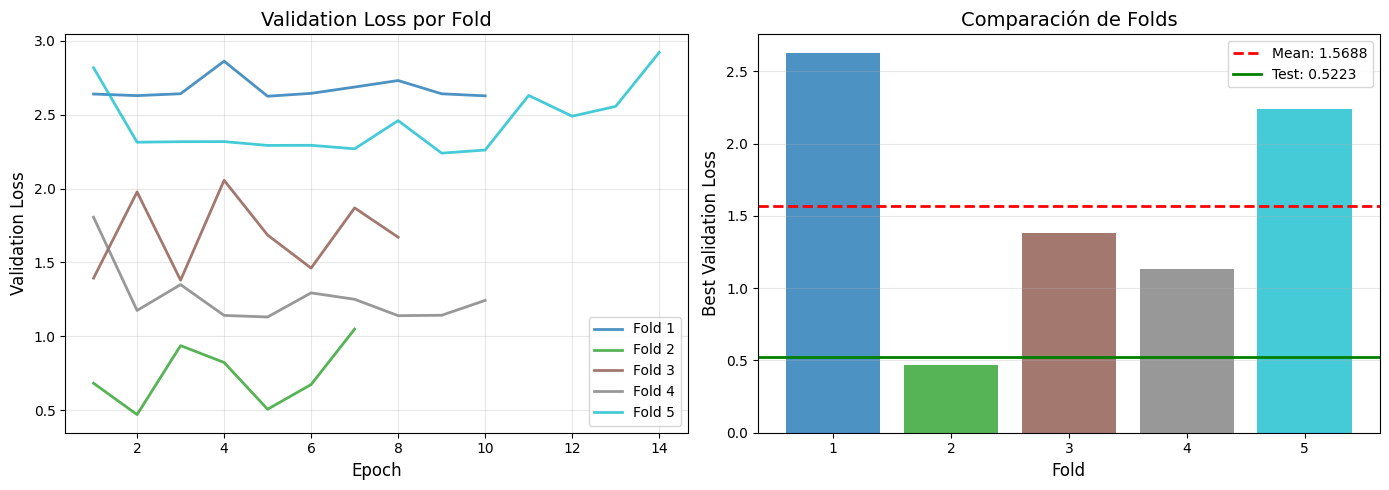

2026/01/15 18:48:33 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



✅ Run completado. Run ID: ba4a0ea7021145a48533a843cc952662


In [ ]:
# ============================================
# Early Stopping Class
# ============================================
class EarlyStopping:
    def __init__(self, patience: int = 5, min_delta: float = 0.0, restore_best: bool = True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best = restore_best
        self.best_loss = float('inf')
        self.best_model_state = None
        self.counter = 0
        self.early_stop = False
        self.best_epoch = 0
    
    def __call__(self, val_loss: float, model: nn.Module, epoch: int):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.best_model_state = copy.deepcopy(model.state_dict())
            self.counter = 0
            self.best_epoch = epoch
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
    
    def restore(self, model: nn.Module):
        if self.restore_best and self.best_model_state is not None:
            model.load_state_dict(self.best_model_state)
            print(f"🔄 Modelo restaurado al mejor epoch: {self.best_epoch}")

# ============================================
# Función de entrenamiento con Early Stopping
# ============================================
def train_one_fold(model: nn.Module, train_dl: DataLoader, val_dl: DataLoader, cfg: CFG, 
                   fold: int = None, patience: int = 5):
    opt = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=0.01)
    loss_fn = nn.SmoothL1Loss()
    early_stopping = EarlyStopping(patience=patience, min_delta=0.001)
    
    history = {"train_loss": [], "val_loss": []}
    fold_str = f"[Fold {fold}] " if fold is not None else ""

    for ep in range(1, cfg.epochs + 1):
        # --- Training ---
        model.train()
        train_total = 0.0
        for embs, valid, y in train_dl:
            embs = embs.to(cfg.device)
            valid = valid.to(cfg.device)
            y = y.to(cfg.device)

            y_hat = model(embs, valid)
            loss = loss_fn(y_hat, y)

            opt.zero_grad(set_to_none=True)
            loss.backward()
            opt.step()

            train_total += float(loss.item())
        
        train_loss = train_total / len(train_dl)
        
        # --- Validation ---
        model.eval()
        val_total = 0.0
        with torch.no_grad():
            for embs, valid, y in val_dl:
                embs = embs.to(cfg.device)
                valid = valid.to(cfg.device)
                y = y.to(cfg.device)

                y_hat = model(embs, valid)
                loss = loss_fn(y_hat, y)
                val_total += float(loss.item())
        
        val_loss = val_total / len(val_dl)
        
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        
        # Loguear métricas en MLFlow
        if fold is not None:
            mlflow.log_metrics({
                f"fold{fold}_train_loss": train_loss,
                f"fold{fold}_val_loss": val_loss
            }, step=ep)
        else:
            mlflow.log_metrics({
                "train_loss": train_loss,
                "val_loss": val_loss
            }, step=ep)
        
        print(f"{fold_str}epoch {ep:02d} | train_loss={train_loss:.4f} | val_loss={val_loss:.4f}")
        
        # Early Stopping check
        early_stopping(val_loss, model, ep)
        if early_stopping.early_stop:
            print(f"{fold_str}⛔ Early stopping en epoch {ep} (patience={patience})")
            break
    
    # Restaurar mejor modelo
    early_stopping.restore(model)
    
    return history, early_stopping.best_loss, early_stopping.best_epoch

# ============================================
# Cross-Validation Training
# ============================================
def cross_validate(ds, trainval_indices, kfold, cfg, d_in, n_folds=5, patience=5):
    fold_results = []
    all_histories = []
    best_fold_model = None
    best_fold_loss = float('inf')
    best_fold_idx = -1
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(trainval_indices), 1):
        print(f"\n{'='*50}")
        print(f"FOLD {fold}/{n_folds}")
        print(f"{'='*50}")
        
        # Mapear índices del fold a índices del dataset original
        train_indices = [trainval_indices[i] for i in train_idx]
        val_indices = [trainval_indices[i] for i in val_idx]
        
        # Crear subsets
        train_subset = Subset(ds, train_indices)
        val_subset = Subset(ds, val_indices)
        
        # Crear DataLoaders
        train_dl = DataLoader(train_subset, batch_size=cfg.batch_size, shuffle=True, collate_fn=collate_pad_chunks)
        val_dl = DataLoader(val_subset, batch_size=cfg.batch_size, shuffle=False, collate_fn=collate_pad_chunks)
        
        print(f"Train: {len(train_subset)} | Val: {len(val_subset)}")
        
        # Crear nuevo modelo para este fold
        model = BidderCountPredictor(
            d_in=d_in, d_model=cfg.d_model, n_heads=cfg.n_heads, 
            ffn_dim=cfg.ffn_dim, dropout=cfg.dropout
        ).to(cfg.device)
        
        # Entrenar fold
        history, best_loss, best_epoch = train_one_fold(
            model, train_dl, val_dl, cfg, fold=fold, patience=patience
        )
        
        fold_results.append({
            "fold": fold,
            "best_val_loss": best_loss,
            "best_epoch": best_epoch,
            "final_train_loss": history["train_loss"][-1],
        })
        all_histories.append(history)
        
        # Guardar mejor modelo
        if best_loss < best_fold_loss:
            best_fold_loss = best_loss
            best_fold_model = copy.deepcopy(model.state_dict())
            best_fold_idx = fold
        
        print(f"[Fold {fold}] Best val_loss: {best_loss:.4f} @ epoch {best_epoch}")
    
    return fold_results, all_histories, best_fold_model, best_fold_idx

# ============================================
# Evaluación en Test Set con métricas de regresión
# ============================================
def evaluate_on_test(model: nn.Module, test_dl: DataLoader, cfg: CFG):
    """
    Evalúa el modelo en el test set y calcula métricas de regresión.
    
    Returns:
        dict con métricas: smooth_l1, mse, rmse, mae, r2
    """
    model.eval()
    
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for embs, valid, y in test_dl:
            embs = embs.to(cfg.device)
            valid = valid.to(cfg.device)
            y = y.to(cfg.device)

            y_hat = model(embs, valid)
            all_preds.append(y_hat.cpu())
            all_targets.append(y.cpu())
    
    # Concatenar todas las predicciones y targets
    preds = torch.cat(all_preds, dim=0).squeeze()  # [N]
    targets = torch.cat(all_targets, dim=0).squeeze()  # [N]
    
    # Calcular métricas
    # MSE - Mean Squared Error
    mse = torch.mean((preds - targets) ** 2).item()
    
    # RMSE - Root Mean Squared Error
    rmse = np.sqrt(mse)
    
    # MAE - Mean Absolute Error
    mae = torch.mean(torch.abs(preds - targets)).item()
    
    # R² - Coeficiente de determinación
    ss_res = torch.sum((targets - preds) ** 2).item()
    ss_tot = torch.sum((targets - torch.mean(targets)) ** 2).item()
    r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0.0
    
    # Smooth L1 Loss (la que usamos para entrenar)
    smooth_l1 = nn.functional.smooth_l1_loss(preds, targets).item()
    
    return {
        "smooth_l1": smooth_l1,
        "mse": mse,
        "rmse": rmse,
        "mae": mae,
        "r2": r2,
        "predictions": preds,
        "targets": targets
    }

# ============================================
# Ejecutar Cross-Validation con MLFlow
# ============================================
PATIENCE = 5  # Early stopping patience

with mlflow.start_run(run_name="cross-chunk-cv"):
    # Loguear parámetros
    mlflow.log_params({
        "model_id": cfg.model_id,
        "max_len": cfg.max_len,
        "stride": cfg.stride,
        "d_model": cfg.d_model,
        "n_heads": cfg.n_heads,
        "ffn_dim": cfg.ffn_dim,
        "dropout": cfg.dropout,
        "batch_size": cfg.batch_size,
        "lr": cfg.lr,
        "max_epochs": cfg.epochs,
        "n_folds": N_FOLDS,
        "early_stopping_patience": PATIENCE,
        "trainval_size": trainval_size,
        "test_size": test_size,
        "d_in": d_in,
    })
    
    # Ejecutar Cross-Validation
    fold_results, all_histories, best_model_state, best_fold = cross_validate(
        ds, trainval_indices, kfold, cfg, d_in, n_folds=N_FOLDS, patience=PATIENCE
    )
    
    # Calcular métricas agregadas de CV
    cv_val_losses = [r["best_val_loss"] for r in fold_results]
    cv_mean = np.mean(cv_val_losses)
    cv_std = np.std(cv_val_losses)
    
    print(f"\n{'='*50}")
    print(f"RESULTADOS CROSS-VALIDATION")
    print(f"{'='*50}")
    for r in fold_results:
        print(f"Fold {r['fold']}: val_loss={r['best_val_loss']:.4f} @ epoch {r['best_epoch']}")
    print(f"\nCV Mean: {cv_mean:.4f} ± {cv_std:.4f}")
    print(f"Mejor fold: {best_fold}")
    
    mlflow.log_metrics({
        "cv_mean_val_loss": cv_mean,
        "cv_std_val_loss": cv_std,
        "best_fold": best_fold,
    })
    
    # Cargar mejor modelo y evaluar en test set
    final_model = BidderCountPredictor(
        d_in=d_in, d_model=cfg.d_model, n_heads=cfg.n_heads,
        ffn_dim=cfg.ffn_dim, dropout=cfg.dropout
    ).to(cfg.device)
    final_model.load_state_dict(best_model_state)
    
    test_metrics = evaluate_on_test(final_model, test_dl, cfg)
    
    print(f"\n{'='*50}")
    print(f"📊 MÉTRICAS DE TEST (modelo del fold {best_fold})")
    print(f"{'='*50}")
    print(f"  Smooth L1 Loss : {test_metrics['smooth_l1']:.4f}")
    print(f"  MSE            : {test_metrics['mse']:.4f}")
    print(f"  RMSE           : {test_metrics['rmse']:.4f}")
    print(f"  MAE            : {test_metrics['mae']:.4f}")
    print(f"  R²             : {test_metrics['r2']:.4f}")
    
    # Loguear métricas en MLFlow
    mlflow.log_metrics({
        "test_smooth_l1": test_metrics["smooth_l1"],
        "test_mse": test_metrics["mse"],
        "test_rmse": test_metrics["rmse"],
        "test_mae": test_metrics["mae"],
        "test_r2": test_metrics["r2"],
    })
    
    # Guardar gráfico de todos los folds
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Subplot 1: Loss curves por fold
    ax1 = axes[0]
    colors = plt.cm.tab10(np.linspace(0, 1, N_FOLDS))
    for i, history in enumerate(all_histories):
        epochs_range = range(1, len(history["train_loss"]) + 1)
        ax1.plot(epochs_range, history["val_loss"], '-', color=colors[i], 
                 label=f'Fold {i+1}', linewidth=2, alpha=0.8)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Validation Loss', fontsize=12)
    ax1.set_title('Validation Loss por Fold', fontsize=14)
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # Subplot 2: Barras de CV losses
    ax2 = axes[1]
    ax2.bar(range(1, N_FOLDS + 1), cv_val_losses, color=colors, alpha=0.8)
    ax2.axhline(cv_mean, color='red', linestyle='--', linewidth=2, label=f'CV Mean: {cv_mean:.4f}')
    ax2.axhline(test_metrics['smooth_l1'], color='green', linestyle='-', linewidth=2, label=f'Test: {test_metrics["smooth_l1"]:.4f}')
    ax2.set_xlabel('Fold', fontsize=12)
    ax2.set_ylabel('Best Validation Loss', fontsize=12)
    ax2.set_title('Comparación de Folds', fontsize=14)
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Subplot 3: Predicciones vs Valores Reales (Scatter)
    ax3 = axes[2]
    preds = test_metrics['predictions'].numpy()
    targets = test_metrics['targets'].numpy()
    ax3.scatter(targets, preds, alpha=0.7, edgecolors='black', linewidth=0.5, s=80)
    
    # Línea de identidad (predicción perfecta)
    lims = [min(targets.min(), preds.min()) - 1, max(targets.max(), preds.max()) + 1]
    ax3.plot(lims, lims, 'r--', linewidth=2, label='Ideal (y=x)')
    ax3.set_xlim(lims)
    ax3.set_ylim(lims)
    
    ax3.set_xlabel('Valor Real (Oferentes)', fontsize=12)
    ax3.set_ylabel('Predicción', fontsize=12)
    ax3.set_title(f'Predicciones vs Real (R²={test_metrics["r2"]:.3f})', fontsize=14)
    ax3.legend(fontsize=10)
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Guardar y loguear gráfico
    plot_path = "./cv_results.png"
    fig.savefig(plot_path, dpi=150)
    mlflow.log_artifact(plot_path)
    plt.show()
    
    # Loguear modelo final
    mlflow.pytorch.log_model(final_model, "best_model")
    
    # Actualizar bidder_predictor global con el mejor modelo
    bidder_predictor = final_model
    
    print(f"\n✅ Run completado. Run ID: {mlflow.active_run().info.run_id}")

## Guardar pesos de BidderCountPredictor

In [28]:
# Guardar mejor modelo del CV en data/
CHECKPOINTS_DIR = "../data/model_checkpoints"
os.makedirs(CHECKPOINTS_DIR, exist_ok=True)
ckpt_path = os.path.join(CHECKPOINTS_DIR, "bidder_predictor_best_cv.pt")
torch.save(bidder_predictor.state_dict(), ckpt_path)
print(f"✅ Modelo guardado en: {ckpt_path}")

✅ Modelo guardado en: ../data/model_checkpoints/bidder_predictor_best_cv.pt


## (4) Inferencia final (BidderPredictionPipeline)

In [ ]:
class BidderPredictionPipeline(nn.Module):
    """
    Pipeline completo de predicción de oferentes.
    Combina ChunkEmbedder + BidderCountPredictor para inferencia end-to-end.
    """
    def __init__(self, embedder: ChunkEmbedder, predictor: BidderCountPredictor):
        super().__init__()
        self.embedder = embedder
        self.predictor = predictor

    @torch.no_grad()
    def predict_one(self, text: str) -> torch.Tensor:
        chunk_vecs = self.embedder(text)       # [N,d] - bfloat16
        chunk_vecs = chunk_vecs.float()        # Convertir a float32
        chunk_vecs = chunk_vecs.unsqueeze(0)   # [1,N,d]
        valid = torch.ones((1, chunk_vecs.size(1)), device=chunk_vecs.device, dtype=torch.bool)
        self.predictor.eval()
        y_hat = self.predictor(chunk_vecs, valid)  # [1,1]
        return y_hat.squeeze(0)

# Crear pipeline completo
pipeline = BidderPredictionPipeline(chunk_embedder, bidder_predictor)

# Ejemplo de inferencia
# f = open("341016.txt", "r")
# test_text = f.read()
# pred = pipeline.predict_one(test_text)
# pred

NameError: name 'modelB' is not defined